In [1]:
try:
  import livelossplot
except ModuleNotFoundError:
  !pip install livelossplot -q

In [2]:
%load_ext autoreload
%autoreload 2

import sys
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import EfficientNetB0
from keras.applications.vgg16 import preprocess_input as preprocess_input_vgg16
from keras.applications.efficientnet import preprocess_input as preprocess_input_efficientnet
from keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Input, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from livelossplot.inputs.keras import PlotLossesCallback

In [3]:
drive.mount('/content/drive')
sys.path.append('/content/drive/MyDrive/Colab Notebooks/')
import utils

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# use_model = VGG16
# model_name = "VGG16"
# preprocessing = preprocess_input_vgg16

use_model = EfficientNetB0
model_name = "EffNetB0"
preprocessing = preprocess_input_efficientnet

In [5]:
data_path = "/content/drive/MyDrive/CAFO_data/forTraining/"

# Code currently does not do anything about the fact that Iowa and Mexico have
# many more farms and not-farms than the other datasets
datasets = ["chl", "mex", "rou", "iowa"]

gdf_list = []
for place in datasets:
  gdf = pd.read_pickle(f'{data_path}{place}_final.pkl')
  print(f"There are {len(gdf)} rows in the {place} dataset")
  if place == "iowa":
    print(f" -- Sampling all not-farms and 500 farms in Iowa")
    gdf1 = gdf[gdf["Farm type"] == "Non-farm"]
    gdf2 = gdf[gdf["Farm type"] != "Non-farm"].sample(500)
    gdf = pd.concat([gdf1, gdf2])
  gdf_list.append(gdf)

data = pd.concat(gdf_list).reset_index(drop=True)

There are 664 rows in the chl dataset
There are 6714 rows in the mex dataset
There are 809 rows in the rou dataset
There are 3127 rows in the iowa dataset
 -- Sampling all not-farms and 500 farms in Iowa


In [6]:
images = []
labels = []
metadata_list = []

for idx, row in data.iterrows():
  # Glomming all farm types into a single "CAFO" class
  if row['Farm type'] in ["Poultry", "Broiler", "Layer", "Pig", "Unknown CAFO"]:
    labels.append("CAFO")
    images.append(row["Sentinel"])
  elif row['Farm type'] == "Non-farm":
    labels.append("Non-farm")
    images.append(row["Sentinel"])
  else:
    print(f"Unexpected farm type, {row['Farm type']}")
  metadata_list.append(row.drop(["Sentinel"]).to_dict())

# Labels --> categorical --> one hot
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
one_hot_labels = to_categorical(encoded_labels, num_classes=len(set(labels)))

class_mapping = dict(zip(encoded_labels, labels))
print("Class mapping:", class_mapping)
n_classes = len(class_mapping)

# Recombine images, labels, and metadata into a DataFrame for shuffling
data1 = list(zip(images, one_hot_labels, metadata_list))
df = pd.DataFrame(data1, columns=['image', 'label', 'metadata'])

df = df.sample(frac=1, random_state=42).reset_index(drop=True)

Class mapping: {1: 'Non-farm', 0: 'CAFO'}


In [7]:
# Create training, validation, and test datasets

# Split into (training+validation) and test sets (10% for testing)
train_val_df, test_df = train_test_split(df, test_size=0.1, random_state=42)

# Split training + validation into training and validation sets (~20% for val)
train_df, val_df = train_test_split(train_val_df, test_size=0.22,\
                                    random_state=42)

# Extract the split data
X_train = np.array(train_df['image'].tolist())
y_train = np.array(train_df['label'].tolist())

X_val = np.array(val_df['image'].tolist())
y_val = np.array(val_df['label'].tolist())

X_test = np.array(test_df['image'].tolist())
y_test = np.array(test_df['label'].tolist())

# The index of each item in X_train etc. should correspond to the index in
# the appropriate dataframe
metadata_train = pd.json_normalize(train_df['metadata'])
metadata_val = pd.json_normalize(val_df['metadata'])
metadata_test = pd.json_normalize(test_df['metadata'])

# Print the number of training, validation, and test images
print(f"Training set: {X_train.shape[0]} images")
print(f"Validation set: {X_val.shape[0]} images")
print(f"Test set: {X_test.shape[0]} images")

# Keep copies of original data as the arrays can get changed by the data
# generators (this should be handled differently?)
X_train_original = np.copy(X_train)
X_val_original = np.copy(X_val)
X_test_original = np.copy(X_test)

Training set: 6098 images
Validation set: 1720 images
Test set: 869 images


In [8]:
# Set up data generators, augmenting training data but not validation + test data

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocessing
    )

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocessing
    )

In [9]:
# Create the model so as to fine-tune only the top 2 (non-convolutional) layers
# This is essentially extracting existing features and re-learning how to
# classify based on them

input_shape=X_train.shape[1:]
optimizer=Adam(learning_rate=0.001)
weights_file = None #f'/content/drive/MyDrive/CAFO_models/better{model_name}_step1.keras'

# Load pretrained layers, excluding fully-connected layers
base_model = use_model(include_top=False,
                  weights='imagenet',
                  input_shape=input_shape)

# Freeze pretrained layers
base_model.trainable = False
top_model = base_model.output

if use_model == VGG16:
  # Create new fully-connected layers for classification
  top_model = Flatten(name="flatten")(top_model)
  top_model = Dense(512, activation='relu')(top_model)
  top_model = Dropout(0.5)(top_model)
  top_model = Dense(256, activation='relu')(top_model)
  top_model = Dropout(0.5)(top_model)
  output_layer = Dense(n_classes, activation='softmax')(top_model)

elif use_model == EfficientNetB0: # or resnet
  top_model = GlobalAveragePooling2D()(top_model)
  output_layer = Dense(n_classes, activation='softmax')(top_model)

# Combine the base (convolutional) and top (fully-connected) layers
model = Model(inputs=base_model.input, outputs=output_layer)

# If we have already done this step, can load saved weights from file
if weights_file is not None:
  print(f'Loading model from {weights_file}')
  model.load_weights(weights_file)

# Compile the model for training.
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [10]:
# Define early stopping + other callbacks.

lr = ReduceLROnPlateau(
                      factor=0.5,
                      monitor='val_loss',
                      min_delta=0,
                      patience=3,
                      min_lr=1e-6,
                      verbose=2
                      )

es = EarlyStopping(
                  monitor='val_loss',
                  mode='min',
                  restore_best_weights=True,
                  min_delta=0,
                  patience=6,
                  verbose=2
                  )

mc = ModelCheckpoint(
                    f'/content/drive/MyDrive/CAFO_models/better{model_name}_step1.keras',
                    monitor='val_accuracy',
                    mode='max',
                    verbose=2,
                    save_best_only=True
                    )

pl = PlotLossesCallback()

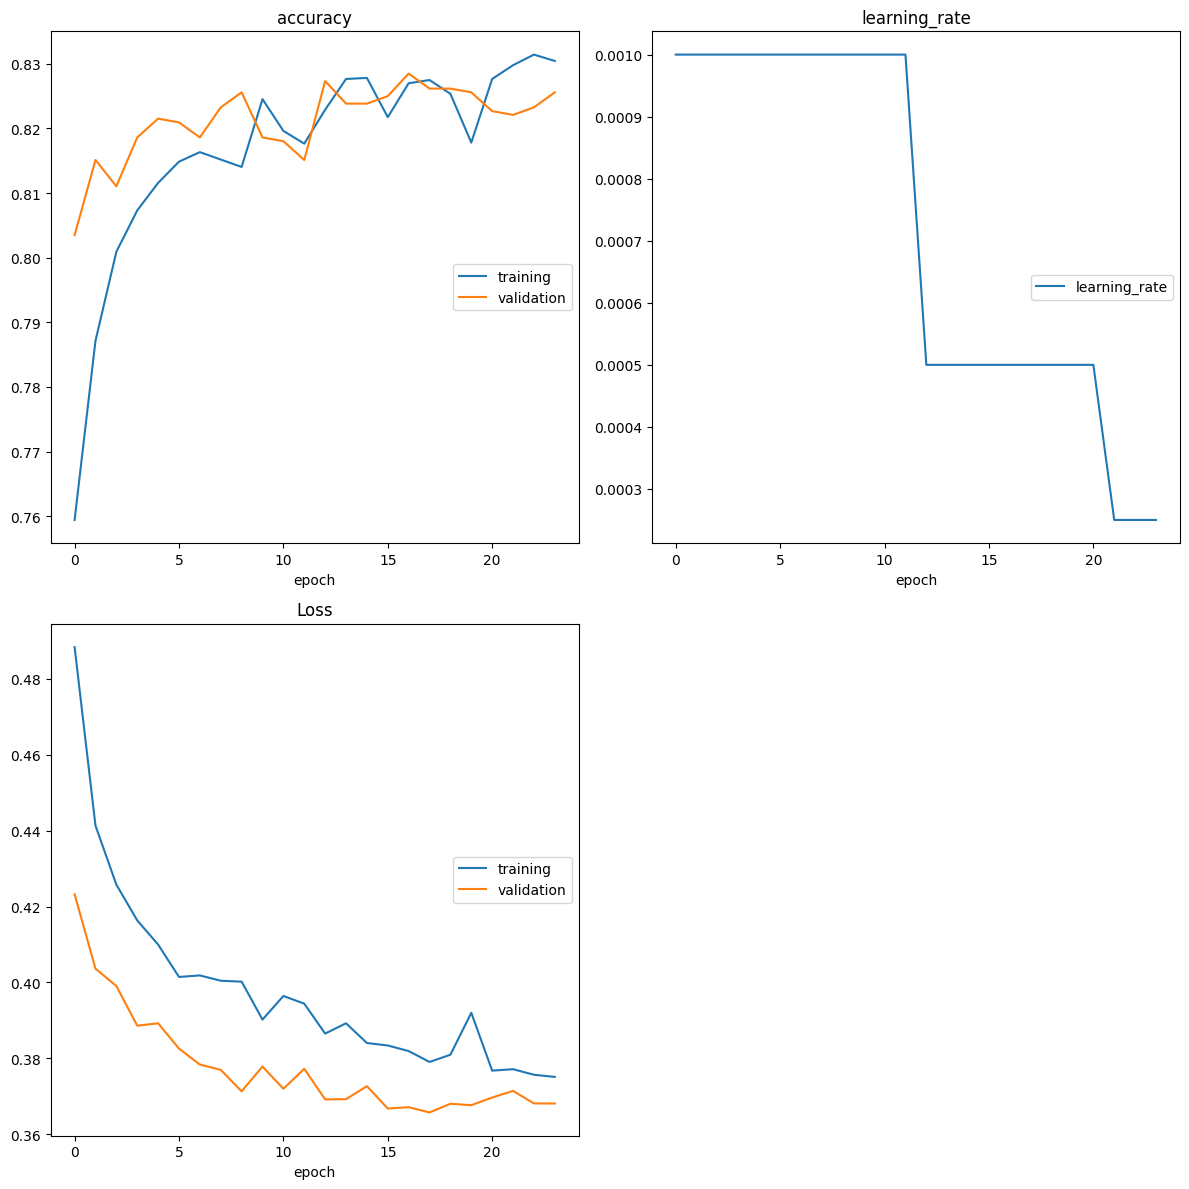

accuracy
	training         	 (min:    0.759, max:    0.831, cur:    0.830)
	validation       	 (min:    0.803, max:    0.828, cur:    0.826)
learning_rate
	learning_rate    	 (min:    0.000, max:    0.001, cur:    0.000)
Loss
	training         	 (min:    0.375, max:    0.488, cur:    0.375)
	validation       	 (min:    0.366, max:    0.423, cur:    0.368)
191/191 - 11s - 55ms/step - accuracy: 0.8304 - loss: 0.3751 - val_accuracy: 0.8256 - val_loss: 0.3681 - learning_rate: 2.5000e-04
Epoch 24: early stopping
Restoring model weights from the end of the best epoch: 18.


In [11]:
# Fit the model, if we haven't reloaded a previously-fitted one

if weights_file is None:

  history = model.fit(
                    train_datagen.flow(X_train, y_train, batch_size=32),
                    validation_data=val_datagen.flow(X_val, y_val, batch_size=32),
                    epochs=50,
                    callbacks=[lr, es, mc, pl],
                    verbose=2
                    )

In [12]:
# Use the model to make predictions for the test data. As
# EarlyStopping.restore_best_weights=True, this should be the best model,
# not just the final epoch's one

results = utils.get_predictions(model, X_test, y_test, preprocessing, metadata_test)

# Generate sklearn classification report
print('\n', classification_report(results["Label"].to_list(),\
                                  results['Model Class'].to_list()))

# Show some of the correctly- and incorrectly-classified images. Use the
# "ascending" kw to say whether the images should be arranged in order
# of ascending probability (True/False)

utils.plot_classified_images(X_test, results, class_mapping, ascending=False)

Output hidden; open in https://colab.research.google.com to view.

In [13]:
# Fine-tune the model

# Set the top block to be trainable
for layer in base_model.layers:
    if use_model == VGG16 and 'block5' in layer.name:
        layer.trainable = True
        print(f"Layer {layer.name} is trainable")
    elif use_model == EfficientNetB0 and 'block7a' in layer.name:
        layer.trainable = True
        print(f"Layer {layer.name} is trainable")

# Compile the model with a lower learning rate
# Model compiling does not change weights; see
# stackoverflow.com/questions/47995324/does-model-compile-initialize-all-the-
# weights-and-biases-in-keras-tensorflow
optimizer=Adam(learning_rate=0.001*0.2)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Update parameters for Reduce LR and EarlyStopping to reduce overfitting
lr = ReduceLROnPlateau(
                      factor=0.5,
                      monitor='val_loss',
                      min_delta=0.03,
                      patience=3,
                      min_lr=1e-6,
                      verbose=2
                      )

es = EarlyStopping(
                  monitor='val_loss',
                  mode='min',
                  restore_best_weights=True,
                  min_delta=0.03,
                  patience=6,
                  verbose=2
                  )

# Specify a new filename for best model
mc = ModelCheckpoint(
                    f'/content/drive/MyDrive/CAFO_models/better{model_name}_step2.keras',
                    monitor='val_accuracy',
                    mode='max',
                    verbose=2,
                    save_best_only=True
                    )

# Reset the plots
pl = PlotLossesCallback()

Layer block7a_expand_conv is trainable
Layer block7a_expand_bn is trainable
Layer block7a_expand_activation is trainable
Layer block7a_dwconv is trainable
Layer block7a_bn is trainable
Layer block7a_activation is trainable
Layer block7a_se_squeeze is trainable
Layer block7a_se_reshape is trainable
Layer block7a_se_reduce is trainable
Layer block7a_se_expand is trainable
Layer block7a_se_excite is trainable
Layer block7a_project_conv is trainable
Layer block7a_project_bn is trainable


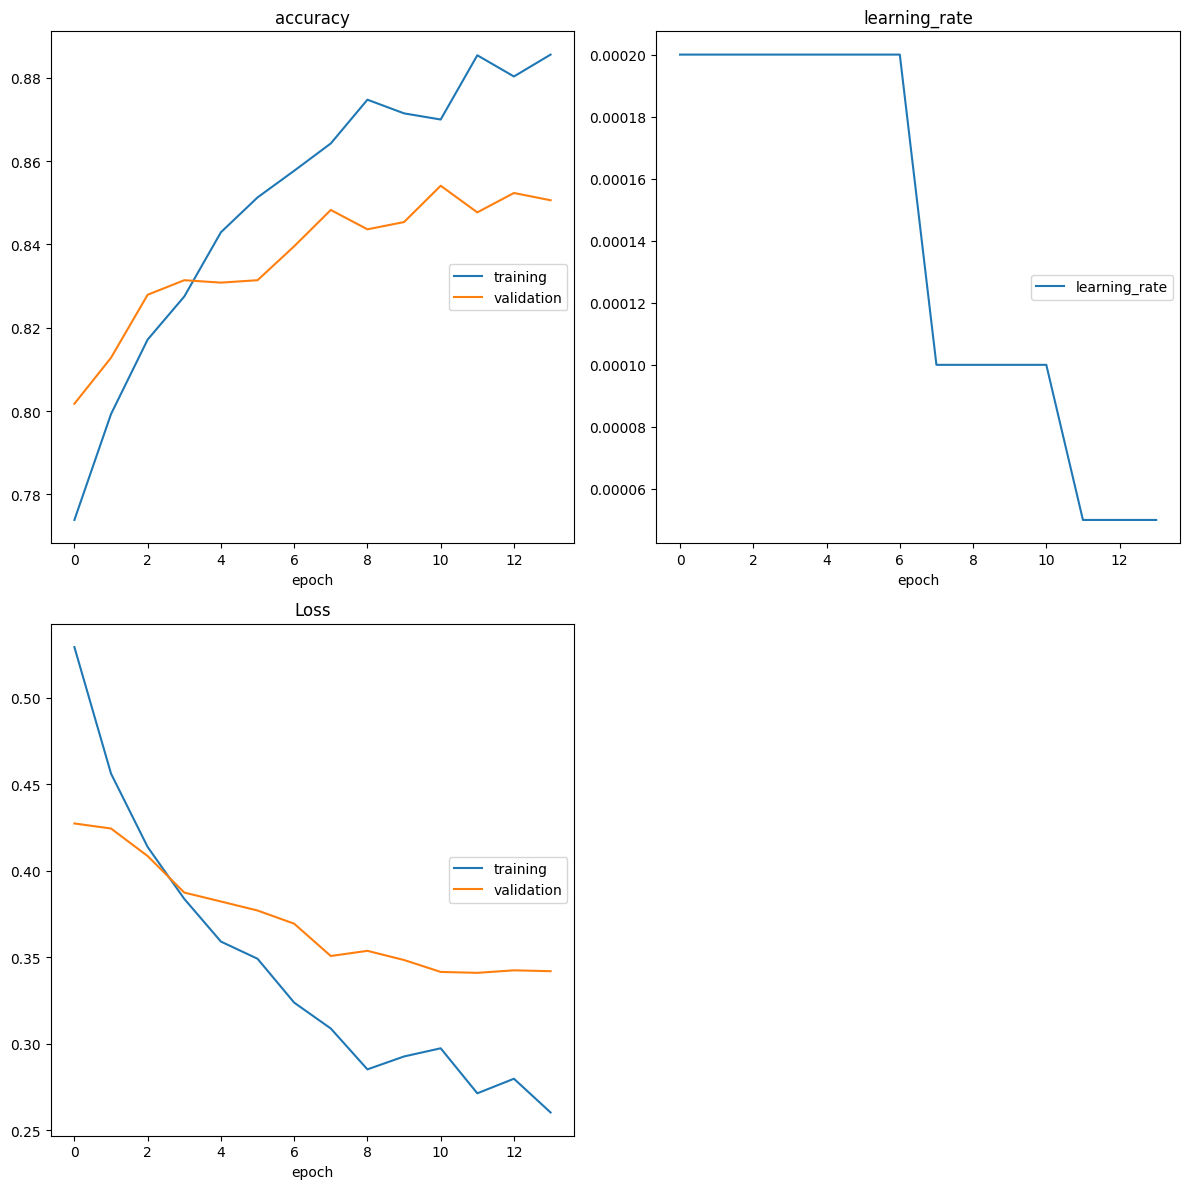

accuracy
	training         	 (min:    0.774, max:    0.886, cur:    0.886)
	validation       	 (min:    0.802, max:    0.854, cur:    0.851)
learning_rate
	learning_rate    	 (min:    0.000, max:    0.000, cur:    0.000)
Loss
	training         	 (min:    0.260, max:    0.529, cur:    0.260)
	validation       	 (min:    0.341, max:    0.427, cur:    0.342)
191/191 - 9s - 48ms/step - accuracy: 0.8855 - loss: 0.2602 - val_accuracy: 0.8506 - val_loss: 0.3419 - learning_rate: 5.0000e-05
Epoch 14: early stopping
Restoring model weights from the end of the best epoch: 8.


In [14]:
weights_file = None #f'/content/drive/MyDrive/CAFO_models/better{model_name}_step2.keras'

if weights_file is not None:
  # Skip fine-tuning and proceed to examine results from existing fine-tuned
  # model
  print(f'Loading weights from {weights_file}')
  model.load_weights(weights_file) #load weights or whole model?

else:

  # Uncomment if this fine-tuning step is interrupted and restarted
  # Otherwise I'm not sure where fitting will start from
  #weights_file = f'/content/drive/MyDrive/CAFO_models/better{model_name}_step1.keras'
  #model.load_weights(weights_file)

  # Fit the model
  ft_history = model.fit(
                    train_datagen.flow(X_train, y_train, batch_size=32),
                    validation_data=val_datagen.flow(X_val, y_val, batch_size=32),
                    epochs=70, #base epochs + fine-tuning ones?
                    callbacks=[lr, mc, es, pl],
                    verbose=2
                    )

In [15]:
results_ft = utils.get_predictions(model, X_test, y_test, preprocessing, metadata_test)

print('\n', classification_report(results_ft["Label"].to_list(),\
                                  results_ft['Model Class'].to_list()))

utils.plot_classified_images(X_test, results_ft, class_mapping, ascending=False)

Output hidden; open in https://colab.research.google.com to view.